# Packages

In [56]:
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor


In [3]:
with zipfile.ZipFile("../data/playground-series-s4e9.zip") as z:
    with z.open("sample_submission.csv") as f:
        sample_submission = pd.read_csv(f)
    with z.open("test.csv") as f:
        test = pd.read_csv(f)
    with z.open("train.csv") as f:
        train = pd.read_csv(f)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            125690 non-null  int64 
 1   brand         125690 non-null  object
 2   model         125690 non-null  object
 3   model_year    125690 non-null  int64 
 4   milage        125690 non-null  int64 
 5   fuel_type     122307 non-null  object
 6   engine        125690 non-null  object
 7   transmission  125690 non-null  object
 8   ext_col       125690 non-null  object
 9   int_col       125690 non-null  object
 10  accident      124058 non-null  object
 11  clean_title   111451 non-null  object
dtypes: int64(3), object(9)
memory usage: 11.5+ MB


In [6]:
selected_cols = ["model_year","milage","price"]

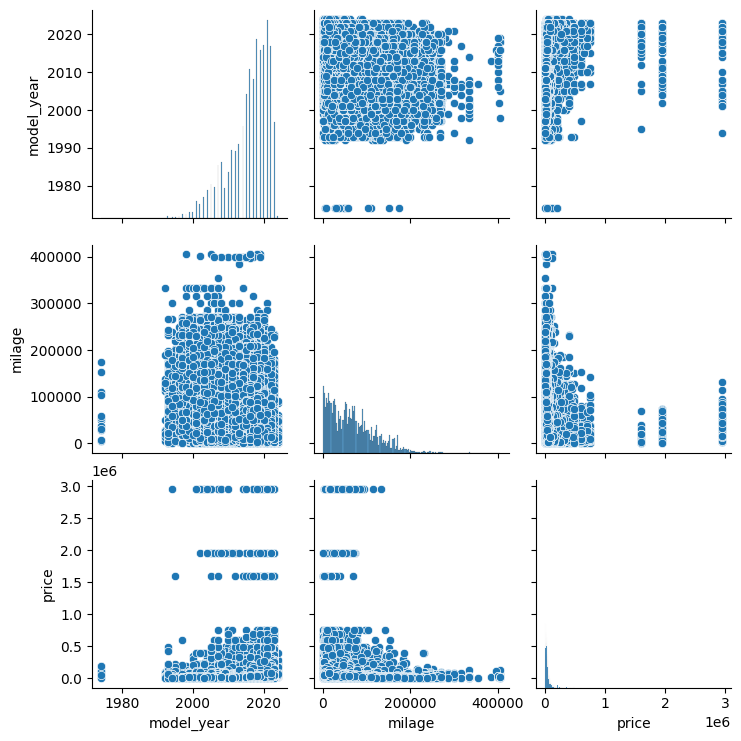

In [7]:
sns.pairplot(train[selected_cols])

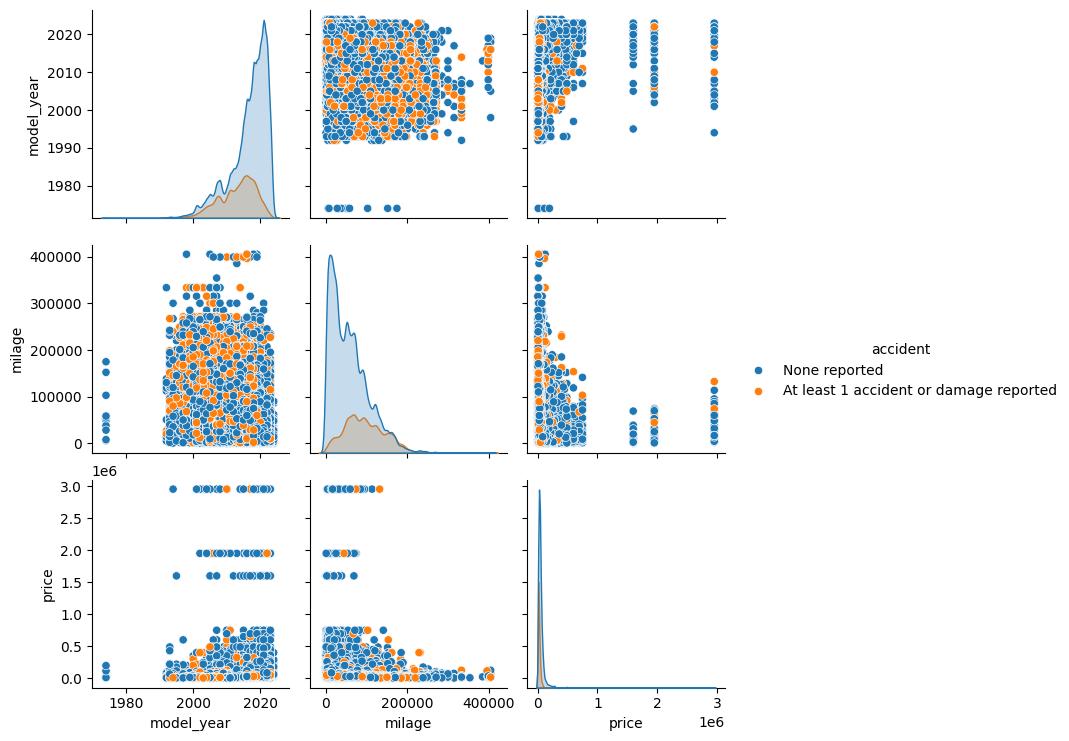

In [7]:
sns.pairplot(train[selected_cols+["accident"]],hue="accident")

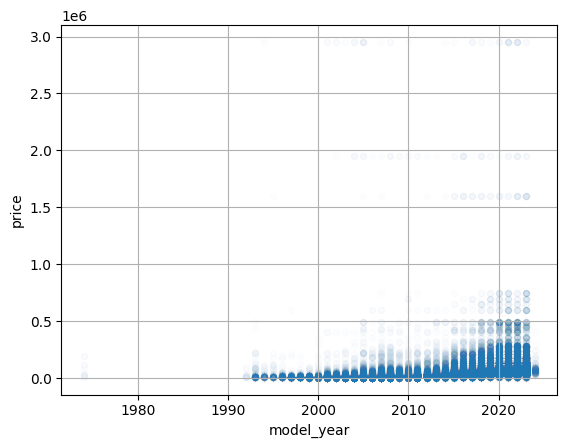

In [11]:
train.plot(kind="scatter", x="model_year", y="price", grid=True, alpha=0.01)
plt.show()

In [12]:
train.describe(include="all")

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
count,188533.000000,188533,188533,188533.000000,188533.000000,183450,188533,188533,188533,188533,186081,167114,1.885330e+05
unique,NaN,57,1897,NaN,NaN,7,1117,52,319,156,2,1,NaN
top,NaN,Ford,F-150 XLT,NaN,NaN,Gasoline,355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,NaN
freq,NaN,23088,2945,NaN,NaN,165940,3462,49904,48658,107674,144514,167114,NaN
mean,94266.000000,NaN,NaN,2015.829998,65705.295174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.387802e+04
std,54424.933488,NaN,NaN,5.660967,49798.158076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.881952e+04
min,0.000000,NaN,NaN,1974.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000e+03
25%,47133.000000,NaN,NaN,2013.000000,24115.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.700000e+04
50%,94266.000000,NaN,NaN,2017.000000,57785.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.082500e+04
75%,141399.000000,NaN,NaN,2020.000000,95400.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.990000e+04


<Axes: ylabel='model_year'>

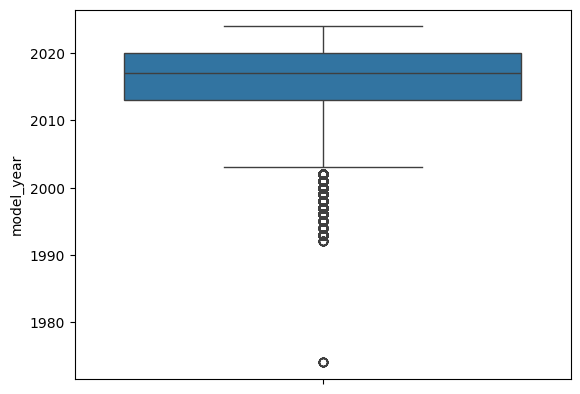

In [13]:
sns.boxplot(y=train["model_year"])

In [8]:
quartiles = train["model_year"].quantile([0.25,0.5,0.75])

In [9]:
quartiles

0.25    2013.0
0.50    2017.0
0.75    2020.0
Name: model_year, dtype: float64

In [10]:
iqr = quartiles[0.75]- quartiles[0.25]
iqr

np.float64(7.0)

In [11]:
delta = (train["model_year"].max()-2013+1.5*iqr)/5
delta

np.float64(4.3)

In [12]:
bins = [float(2024-delta*(5-i)) for i in range(6)]

In [13]:
bins[0], bins[5] = -np.inf, np.inf

In [14]:
bins

[-inf, 2006.8, 2011.1, 2015.4, 2019.7, inf]

In [15]:
train["model_cat"] = pd.cut(train["model_year"],
                               bins=bins,
                               labels=[1, 2, 3, 4, 5])

In [16]:
strat_train_set, strat_test_set = train_test_split(
    train, test_size=0.2, stratify=train["model_cat"], random_state=42)

In [21]:
strat_test_set.count(),strat_train_set.count()

(id              37707
 brand           37707
 model           37707
 model_year      37707
 milage          37707
 fuel_type       36691
 engine          37707
 transmission    37707
 ext_col         37707
 int_col         37707
 accident        37216
 clean_title     33420
 price           37707
 model_cat       37707
 dtype: int64,
 id              150826
 brand           150826
 model           150826
 model_year      150826
 milage          150826
 fuel_type       146759
 engine          150826
 transmission    150826
 ext_col         150826
 int_col         150826
 accident        148865
 clean_title     133694
 price           150826
 model_cat       150826
 dtype: int64)

In [23]:
strat_test_set.count()/strat_train_set.count()

id              0.250003
brand           0.250003
model           0.250003
model_year      0.250003
milage          0.250003
fuel_type       0.250009
engine          0.250003
transmission    0.250003
ext_col         0.250003
int_col         0.250003
accident        0.249998
clean_title     0.249974
price           0.250003
model_cat       0.250003
dtype: float64

In [24]:
strat_train_set, strat_dev_set = train_test_split(
    strat_train_set, test_size=0.2, stratify=strat_train_set["model_cat"], random_state=42)

In [25]:
strat_dev_set.count()/strat_train_set.count()

id              0.250008
brand           0.250008
model           0.250008
model_year      0.250008
milage          0.250008
fuel_type       0.250162
engine          0.250008
transmission    0.250008
ext_col         0.250008
int_col         0.250008
accident        0.249906
clean_title     0.249488
price           0.250008
model_cat       0.250008
dtype: float64

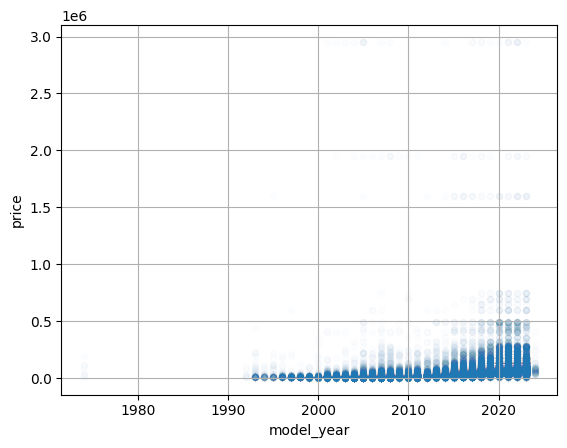

In [54]:
strat_train_set.plot(kind="scatter", x="model_year", y="price", grid=True, alpha=0.01)
plt.show()

<Axes: ylabel='price'>

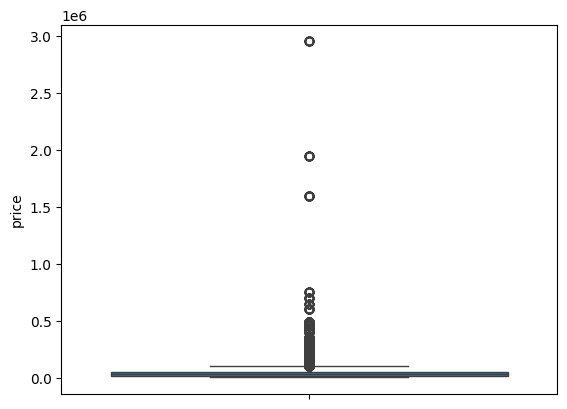

In [55]:
sns.boxplot(y=strat_train_set["price"])

In [56]:
strat_train_set["price"].describe()

count    1.206600e+05
mean     4.373486e+04
std      7.759015e+04
min      2.000000e+03
25%      1.700000e+04
50%      3.077500e+04
75%      4.990000e+04
max      2.954083e+06
Name: price, dtype: float64

In [26]:
price_quartiles = strat_train_set["price"].quantile([0.25,0.5,0.75])

In [27]:
q4 = float(price_quartiles[0.75]+1.5*(price_quartiles[0.75]-price_quartiles[0.25]))
q1 = float(price_quartiles[0.25]-1.5*(price_quartiles[0.75]-price_quartiles[0.25]))
q1,q4, strat_train_set["price"].min(), strat_train_set["price"].max()

(-32350.0, 99250.0, np.int64(2000), np.int64(2954083))

In [28]:
strat_train_set[strat_train_set["price"]<=q4].count()/ strat_train_set.count()

id              0.942831
brand           0.942831
model           0.942831
model_year      0.942831
milage          0.942831
fuel_type       0.943471
engine          0.942831
transmission    0.942831
ext_col         0.942831
int_col         0.942831
accident        0.943157
clean_title     0.950672
price           0.942831
model_cat       0.942831
dtype: float64

In [29]:
model_year_q0 = float(quartiles[0.25]-1.5*iqr)
model_year_q0

2002.5

In [31]:
strat_train_set[strat_train_set["model_year"]>= model_year_q0].count()/strat_train_set.count()

id              0.973313
brand           0.973313
model           0.973313
model_year      0.973313
milage          0.973313
fuel_type       0.972596
engine          0.973313
transmission    0.973313
ext_col         0.973313
int_col         0.973313
accident        0.973233
clean_title     0.970280
price           0.973313
model_cat       0.973313
dtype: float64

In [32]:
strat_train_set[(strat_train_set["model_year"]>= model_year_q0) &
                                  (strat_train_set["price"]<=q4)].count()/strat_train_set.count()

id              0.916509
brand           0.916509
model           0.916509
model_year      0.916509
milage          0.916509
fuel_type       0.916442
engine          0.916509
transmission    0.916509
ext_col         0.916509
int_col         0.916509
accident        0.916751
clean_title     0.921326
price           0.916509
model_cat       0.916509
dtype: float64

In [33]:
strat_train_set =  strat_train_set[(strat_train_set["model_year"]>= model_year_q0) &
                                  (strat_train_set["price"]<=q4)]

<Axes: ylabel='price'>

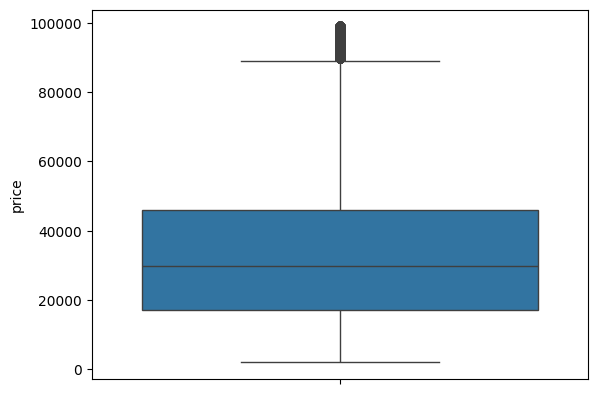

In [34]:
sns.boxplot(y=strat_train_set["price"])

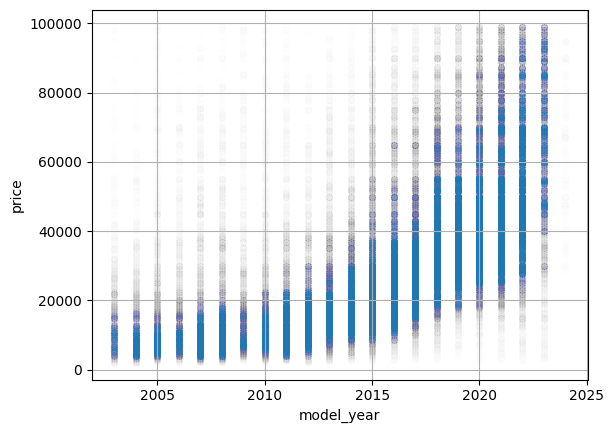

In [35]:
strat_train_set.plot(kind="scatter", x="model_year", y="price", grid=True, alpha=0.002)
plt.show()

In [37]:
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(strat_train_set[["model_year"]])

In [40]:
y = strat_train_set["price"].copy()

In [42]:
y.mean()

np.float64(33987.88129600492)

In [44]:
y

149592    41900
128187    17999
188040    44249
91342     42000
16437     33800
          ...  
90322     32000
162630     2500
145480    12000
67580     29000
501       42500
Name: price, Length: 110586, dtype: int64

In [43]:
strat_train_set[["model_year","price"]]

,model_year,price
149592,2022,41900
128187,2006,17999
188040,2019,44249
91342,2021,42000
16437,2013,33800
...,...,...
90322,2019,32000
162630,2005,2500
145480,2016,12000
67580,2014,29000


In [45]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())


# Train models

In [48]:

lin_reg = LinearRegression()
tree_reg = DecisionTreeRegressor(random_state=42)
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)

In [49]:
linear_rmses = -cross_val_score(lin_reg, X_scaled, y,
                              scoring="neg_root_mean_squared_error", cv=10)

In [50]:
display_scores(linear_rmses)

Scores: [16602.10700697 16506.8443694  16761.25854337 16447.54503073
 16435.38655813 16406.39367263 16505.24902647 16624.23065162
 16729.97349051 16648.88283507]
Mean: 16566.787118489065
Standard deviation: 118.45961251568387


In [51]:
tree_rmses = -cross_val_score(tree_reg, X_scaled, y,
                              scoring="neg_root_mean_squared_error", cv=10)

In [53]:
display_scores(tree_rmses)

Scores: [15814.5690128  15720.07631307 15916.11628357 15618.93808339
 15625.70274652 15543.66585364 15716.93785597 15690.86518347
 15994.72392972 15867.6141633 ]
Mean: 15750.920942545814
Standard deviation: 136.4420979796443


In [54]:
rf_rmses = -cross_val_score(forest_reg, X_scaled, y,
                              scoring="neg_root_mean_squared_error", cv=10)

In [55]:
display_scores(rf_rmses)

Scores: [15814.44583809 15720.23434323 15915.90993105 15618.50219814
 15625.85822449 15543.49692927 15716.76174708 15691.09537468
 15995.18979977 15867.61505911]
Mean: 15750.910944490806
Standard deviation: 136.53912051540394


In [57]:
forest_reg.fit(X_scaled, y)
y_hat = forest_reg.predict(X_scaled)
forest_rmse = mean_squared_error(y, y_hat,
                                 squared=False)
forest_rmse

/usr/local/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


np.float64(15748.298595337686)

In [58]:
X_scaled_dev = std_scaler.transform(strat_dev_set[["model_year"]])

In [59]:
y_dev = strat_dev_set["price"].copy()

In [60]:
y_dev_hat = forest_reg.predict(X_scaled_dev)
forest_rmse = mean_squared_error(y_dev, y_dev_hat,
                                 squared=False)
forest_rmse

/usr/local/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


np.float64(78949.93950604755)